# Задание 1. Создайте и обучите U-Net-подобную сеть для сегментации документов.

В качастве датасета используется фрагмент [midv500](https://arxiv.org/abs/1807.05786). Это датасет, содержащий фотографии документов, таких как паспорт или водительское удостоверение.

Подзадачи:
- Загрузить данные
- Описать модель
- В качестве loss использовать BCE ([BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) или [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html))
- Убедиться, что модель обучается



 Загрузка данныx







In [1]:
import glob
from PIL import Image
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

In [2]:
! wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/midv500p.zip
! unzip -qn midv500p.zip
! rm midv500p.zip

--2024-09-29 19:58:45--  https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/midv500p.zip
Resolving edunet.kea.su (edunet.kea.su)... 185.30.98.120
Connecting to edunet.kea.su (edunet.kea.su)|185.30.98.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9183651 (8.8M) [application/zip]
Saving to: ‘midv500p.zip’

midv500p.zip        100%[===================>]   8.76M  4.09MB/s    in 2.1s    

2024-09-29 19:58:49 (4.09 MB/s) - ‘midv500p.zip’ saved [9183651/9183651]



Dataloader.

MaskDataset возвращает часть датасета для обучения при train_part == True, и тестовую часть при False.

Каждый экземпляр датасета состоит из двух изображений: входного изображения и размеченной маски.

In [3]:
class MaskDataset(Dataset):
    def __init__(self, train_part=True, transform=None, path="midv500p"):
        self.transform = transform
        path += "/train" if train_part else "/val"
        files = glob.glob(path + "/image/*")
        self.loaded_images = []
        self.loaded_masks = []

        for filename in files:
            self.loaded_images.append(Image.open(filename))
            mask_fn = filename.replace("image", "mask").replace("jpg", "png")
            self.loaded_masks.append(Image.open(mask_fn))

    def __getitem__(self, i):
        img = self.loaded_images[i]
        mask = self.loaded_masks[i]

        # Not accept random transform, for these use Albumentation library
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

    def __len__(self):
        return len(self.loaded_images)

Подумайте, какие аугментации/нормализации приемлемы, и примените их. (В baseline-классе применяется одинаковая аугментация для изображения и для маски)

P.S. Допускается использовать библиотеку [albumentation](https://github.com/albumentations-team/albumentations)

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((224, 224))]
)  # Augmentations
transform_val = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((224, 224))]
)

trainset = MaskDataset(train_part=True, transform=transform_train)
valset = MaskDataset(train_part=False, transform=transform_val)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)

In [5]:
print(len(trainset))

553


Убедитесь, что код работает. Для этого воспользуйтесь приведенным ниже тестом.

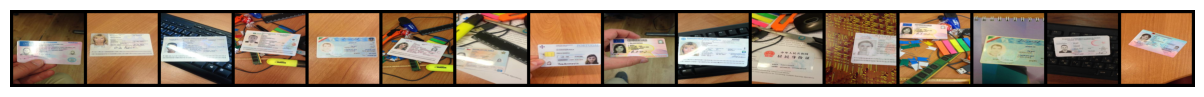

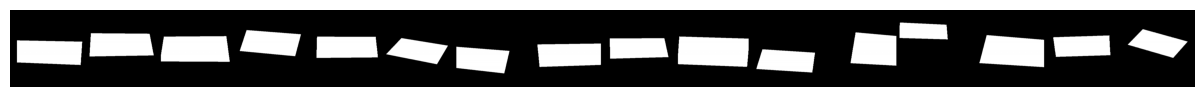

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["figure.figsize"] = (32, 1)


def show(batch, cols=16):
    cols = min(cols, len(batch))
    img_grid = make_grid(batch[:cols], padding=10, nrow=cols)
    plt.figure(figsize=(cols, 1))
    plt.axis("off")
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))


images, masks = next(iter(train_loader))

show(images)
show(masks)

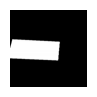

In [7]:
show(trainset[0][1])

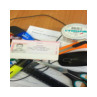

In [8]:
show(trainset[0][0])

Опишите структуру  модели

Рекомендуется использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) - подобную архитектуру.

Однако вы можете ограничиться 2-3 -мя сжимающими и таким  же количеством разжимающих слоев.


In [9]:
from torch import nn


class MiniUnet(nn.Module):
    def __init__(self):
        super().__init__()
        # Your code here

    def forward(self, x):
        # Your code here
        return out  # Segmentation mask

In [10]:
import torch
from torch import nn

class MiniUnet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)

        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)

        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)

        dec1 = self.upsample1(enc2_pool)
        dec1 = torch.cat((dec1, enc2), dim=1)
        dec1_out = self.decoder1(dec1)

        dec2 = self.upsample2(dec1_out)
        dec2 = torch.cat((dec2, enc1), dim=1)
        out = self.decoder2(dec2)

        out = self.final_conv(out)

        return out

Проверим нашу модель

In [11]:
from torchsummary import summary

model = MiniUnet()
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          18,496
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
  ConvTranspose2d-12        [-1, 128, 112, 112]          65,664
           Conv2d-13        [-1, 128, 112, 112]         295,040
      BatchNorm2d-14        [-1, 128, 1

Обучите модель

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
def train(model, criterion, optimizer, epoch=None, masks_in_progress=[]):
    ep_loss = 0
    model.train()
    for img_batch, masks_batch in train_loader:
        optimizer.zero_grad()
        output = model(img_batch.to(device))
        loss = criterion(output, masks_batch.to(device))
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()

    val_loss = 0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            img_batch, masks_batch = batch
            output = model(img_batch.to(device))
            loss = criterion(output, masks_batch.to(device))
            val_loss += loss.item()
            if i == 0:
                masks_in_progress.append(output[1].cpu())

    print(
        "Epoch {} Train loss {:.2f} Val loss {:.2f}".format(
            epoch, ep_loss / len(train_loader), val_loss / len(val_loader)
        )
    )

In [14]:
model = MiniUnet()
criterion = nn.BCEWithLogitsLoss()
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)

In [15]:
masks_in_progress = []
for epoch in range(15):
    train(model, criterion, optimizer, epoch, masks_in_progress)

Epoch 0 Train loss 0.56 Val loss 0.51
Epoch 1 Train loss 0.48 Val loss 0.47
Epoch 2 Train loss 0.45 Val loss 0.46
Epoch 3 Train loss 0.43 Val loss 0.45
Epoch 4 Train loss 0.41 Val loss 0.43
Epoch 5 Train loss 0.40 Val loss 0.45
Epoch 6 Train loss 0.39 Val loss 0.43
Epoch 7 Train loss 0.38 Val loss 0.41
Epoch 8 Train loss 0.37 Val loss 0.41
Epoch 9 Train loss 0.36 Val loss 0.41
Epoch 10 Train loss 0.35 Val loss 0.38
Epoch 11 Train loss 0.35 Val loss 0.41
Epoch 12 Train loss 0.34 Val loss 0.40
Epoch 13 Train loss 0.34 Val loss 0.37
Epoch 14 Train loss 0.33 Val loss 0.36


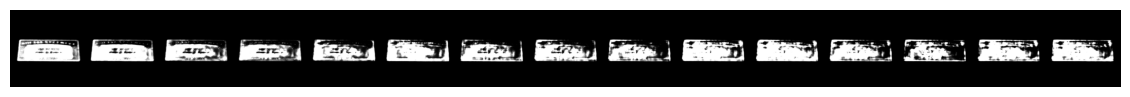

In [16]:
show(masks_in_progress)

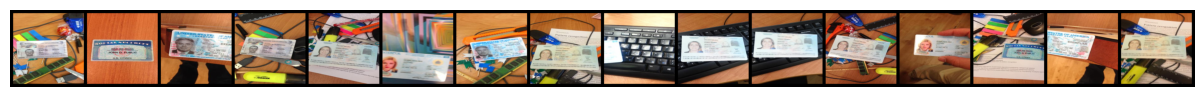

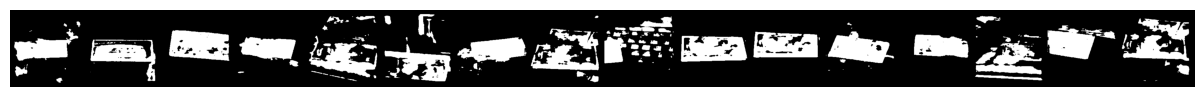

In [17]:
def show_valset_pred(model, cols=16):
    images, pred_masks = [], []
    for batch in valset:
        with torch.no_grad():
            img, mask = batch
            images.append(img.unsqueeze(0))
            output = model(img.unsqueeze(0).to(device))
            pred_masks.append(output.cpu())
    show(torch.stack(images).squeeze()[:cols, ...])
    binary_mask = torch.stack(pred_masks) > 0.5
    show(binary_mask.squeeze(1).float()[:cols, ...])


show_valset_pred(model)

## Формат результата

Сегментированные изображения документов:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX12/result_1_task_ex12_v1.png"  >

# Задание 2. Замените лосс-функцию.



In [18]:
!pip install -q segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.7 MB/s eta 0:00:00


In [21]:
import segmentation_models_pytorch as smp

model = MiniUnet()
model.train()
model.to(device)

criterion = smp.losses.JaccardLoss(smp.losses.MULTILABEL_MODE, from_logits=True)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)

In [22]:
masks_in_progress = []
for epoch in range(15):
    train(model, criterion, optimizer, epoch, masks_in_progress)

Epoch 0 Train loss 0.67 Val loss 0.61
Epoch 1 Train loss 0.59 Val loss 0.59
Epoch 2 Train loss 0.58 Val loss 0.59
Epoch 3 Train loss 0.57 Val loss 0.58
Epoch 4 Train loss 0.56 Val loss 0.57
Epoch 5 Train loss 0.55 Val loss 0.57
Epoch 6 Train loss 0.54 Val loss 0.55
Epoch 7 Train loss 0.53 Val loss 0.55
Epoch 8 Train loss 0.52 Val loss 0.54
Epoch 9 Train loss 0.51 Val loss 0.53
Epoch 10 Train loss 0.51 Val loss 0.53
Epoch 11 Train loss 0.50 Val loss 0.51
Epoch 12 Train loss 0.50 Val loss 0.52
Epoch 13 Train loss 0.49 Val loss 0.51
Epoch 14 Train loss 0.48 Val loss 0.50


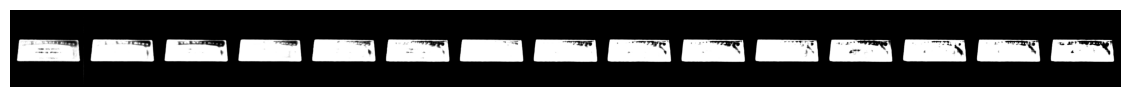

In [23]:
show(masks_in_progress)

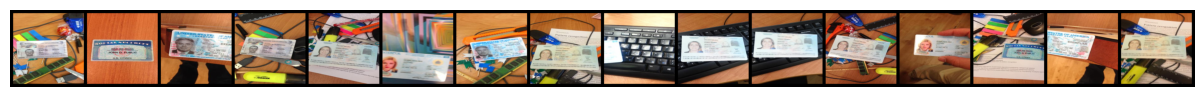

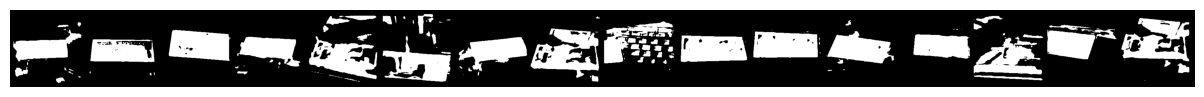

In [24]:
show_valset_pred(model)

## Формат результата

Сегментированные изображения документов

Пример изображения:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX12/result_1_task_ex12_v1.png"  width="600">

# Задание 3. Собственные аугментации

В этом задании предлагается применить к датасету CIFAR-10 аугментации и визуализировать получившиеся результаты. Требуется воспользоваться готовыми аугментациями из `torchvision.transforms`, а также реализовать собственный метод для аугментации изображений.

In [25]:
import os
import shutil

import torchvision
from torch.utils.data import DataLoader


def show_images(dataset, tag, img_count=32):
    """
    Helper method to display first img_count images from dataset
    """

    loader = DataLoader(dataset, batch_size=img_count)

    # Get first batch from dataloader
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # create grid of images
    img_grid = torchvision.utils.make_grid(images)

    # plot
    plt.figure(figsize=(10,7))
    plt.imshow(img_grid.permute((1, 2, 0)))
    plt.title(tag)
    plt.axis("off")
    plt.show()

Загрузите CIFAR-10 и

* Выберите два преобразования из [списка](https://pytorch.org/vision/stable/transforms.html)

* Примените их к изображениям из датасета
* Выведите измененные изображения




100%|██████████| 170498071/170498071 [00:04<00:00, 40635445.91it/s]


Extracting content/cifar-10-python.tar.gz to content


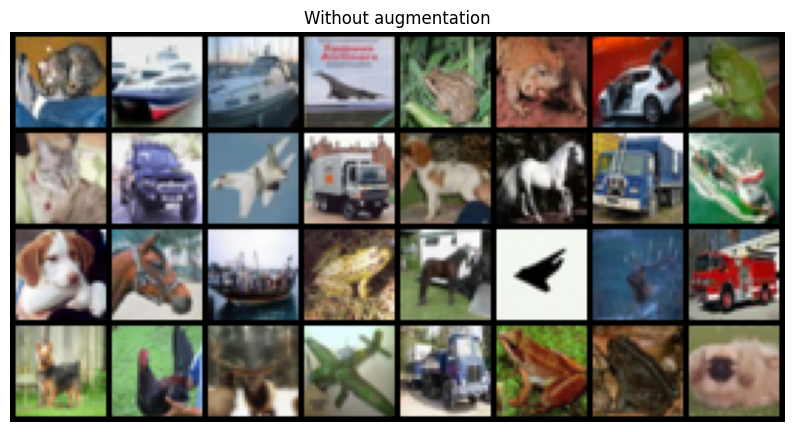

In [26]:
from torchvision import datasets, transforms

testset = datasets.CIFAR10(
    "content",
    train=False,
    transform=transforms.Compose([transforms.ToTensor()]),
    download=True,
)

show_images(testset, "Without augmentation")

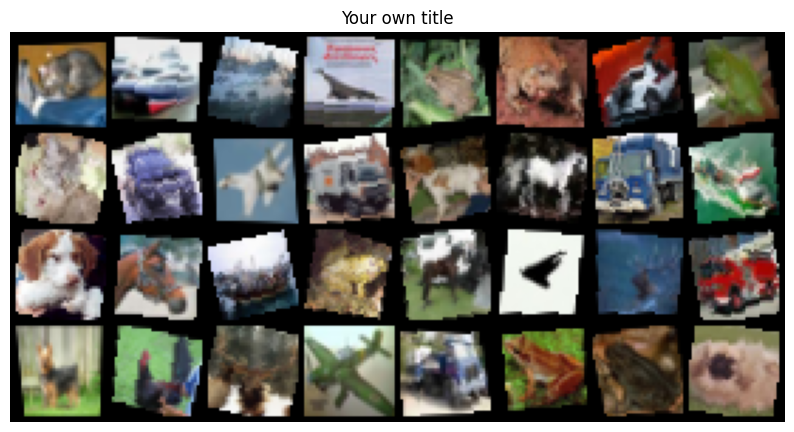

In [27]:
base_augmentation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.8),
        transforms.RandomRotation(15)
    ]
)

testset.transform = base_augmentation
show_images(testset, "Your own title")

### Создание собственной аугментации
* Создайте собственную аугментацию которой нет в `torchvision.transforms`. Например: сделайте изображение квадратным при помощи padding или обнулите чать пикселей или уменьшите изображение и затем восстановите его до прежнего размера ...

* Выведите измененные изображения. При использовании функции `show_images` обратите внимание, что список трансформаций должен содержать `transforms.ToTensor()`.

In [28]:
class Padding(object):
    def __call__(self, img):
        width, height = img.size
        max_dim = max(width, height)
        new_img = Image.new("RGB", (max_dim, max_dim), (0, 0, 0))
        new_img.paste(img, ((max_dim - width) // 2, (max_dim - height) // 2))
        return new_img

class Zero(object):
    def __call__(self, img):
        img_array = np.array(img)
        h, w, _ = img_array.shape
        mask = np.random.rand(h, w) < 0.1
        img_array[mask] = 0
        return Image.fromarray(img_array)

class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        img_resized = img.resize((self.size, self.size))
        return img_resized.resize(img.size)

Делаем изображение квадратным с использованием padding и обнуляем часть пикселей и уменьшим изображение

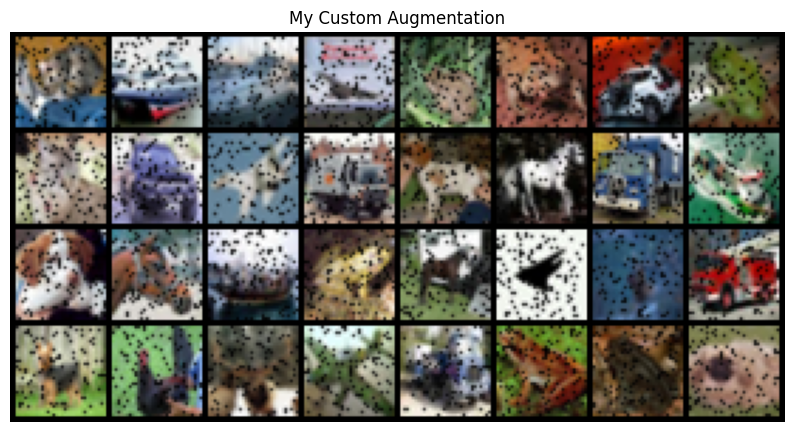

In [29]:
custom_augmentation = transforms.Compose(
    [
        Padding(),
        Zero(),
        Resize(size=64),
        transforms.ToTensor()
    ]
)

testset.transform = custom_augmentation
show_images(testset, "My Custom Augmentation")

## Формат результата

Выведенные изображения:
1. без аугментаций,
2. с двумя аугментациями из torchvision,
3. со своей собственной аугментацией.

# Задание 4. Наука 2.0.

В этом задании мы будем работать с [**EuroSAT Dataset**](https://github.com/phelber/eurosat). В датасете представленны космоснимки со спутника Sentinel-2, которые находятся в открытом и свободном доступе в рамках программы наблюдения Земли - Copernicus. Датасет охватывает 13 спектральных диапазонов и состоит из 10 классов с общим количеством 27 000 размеченых и привязанных к местности изображений.

## Формат результата

* Графики loss и accuracy при обучении


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_5_ex07_v1.png" width="1200" >

* Занчение accuracy на тесте должно составить не менее 0.9




## Загрузка данных

Воспользуемся пакетом [torchsat](https://torchsat.readthedocs.io/en/latest/index.html) для работы с датасетом

In [30]:
from IPython.display import clear_output

!pip install torchsat
clear_output()

Загрузка данных в нем пока не поддерживается :( придется загрузить и распаковать архив самостоятельно:

In [31]:
# !mkdir -p /content/eurosat-ms
# !wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/EuroSATallBands.zip
# !unzip EuroSATallBands.zip -d /content/eurosat-ms
# !rm EuroSATallBands.zip
# clear_output()

In [32]:
!mkdir -p /content/eurosat-ms
!wget https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/EuroSAT.zip
!unzip EuroSAT.zip -d /content/eurosat-rgb
!rm EuroSAT.zip
clear_output()

In [33]:
# import torchsat
# path = '/content/eurosat-ms/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/'
# dataset = torchsat.datasets.utils.tifffile_loader(path)

In [34]:
from torchsat.datasets.eurosat import EuroSAT
path = '/content/eurosat-rgb/2750'
dataset = EuroSAT(root=path)

## Предварительный анализ

Посмотрим что мы скачали

In [35]:
print("Image count: ", len(dataset))
image, label = dataset[0]
print("Type: ", type(image), "shape", image.shape, "Class", dataset.classes[label])

Image count:  27000
Type:  <class 'numpy.ndarray'> shape (64, 64, 3) Class AnnualCrop


Ага! У нас  3 канала как в обычном RGB, а вообще у Sentinel-2 их аж целых 13! Но для учебной цели бьудем работать с видимым спектром. Давайте на него посмотрим

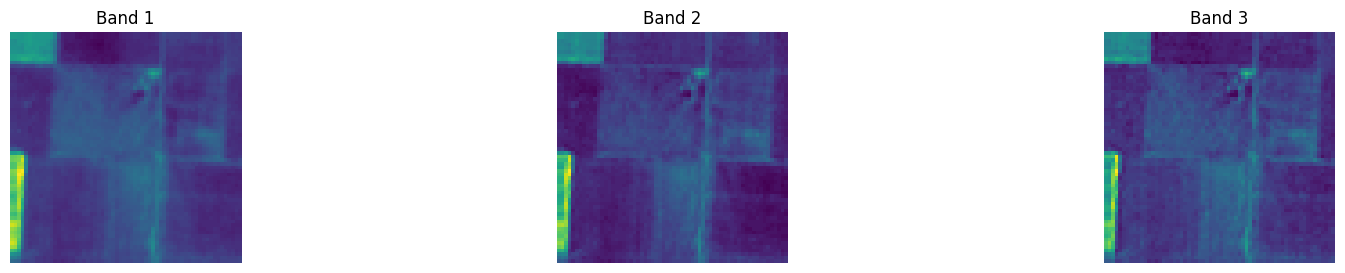

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(20, 3))
for band, a in enumerate(ax):
    a.imshow(image[:, :, band])
    a.axis("off")
    band+=1
    a.set_title("Band %i" % band)

Что значат эти Bands?

* Band 0 – Coastal aerosol
* Band 1 – Blue
* Band 2 – Green
* Band 3 – Red
* Band 4-6 – Vegetation red edge
* Band 7 – NIR (near infrared range)
* Band 8 – Narrow NIR
* Band 9 – Water vapour
* Band 10-12 – SWIR (short wave infrared spectral range)


In [37]:
import torch
import numpy as np

##  Посмотрите какие есть классы в нашем `dataset`

In [38]:
for clas in dataset.classes:
    print(clas)

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake


## Подготовка к обучению



Разобьем датасет на Train, Validation и Test и инициализируем загрузчики

In [39]:
import torch


train_set, val_set, test_set = torch.utils.data.random_split(
    dataset,
    [int(len(dataset) * 0.7), int(len(dataset) * 0.15), int(len(dataset) * 0.15)],
)

Предобработайте данные, создайте загрузчики (Dataloaders)

In [40]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

Dataloader не сможет преобразовать uint16 numpy массив к тензору и выдаст ошибку. Стандартный ToTensor рассчитан на работу с картинками где значения яркости находятся в интервале 0 .. 255 и тоже не сработает. Придется добавить к датасету трансформацию которая преобразует значения во float, например так.

In [41]:
from torchvision import transforms  # models, datasets,

dataset.transform = transforms.Compose([lambda np_arr: np_arr.astype(float)])

In [42]:
dataset.transform = transforms.Compose([torchvision.transforms.ToTensor(),])

Не забудьте сделать другие преобразования. На вход нейросети нужно подать тензор с размерностью (batsh, C, H, W).


In [43]:
img, label = dataset[0]
img.shape

torch.Size([3, 64, 64])

##  Обучите сеть



Адаптируем ResNet для нового размера данных, по сути ничего енять не надо, ведь у нас все еще 3 канала, а не 13

In [44]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:

    """
        Groups contain a list of variables to output, like ["loss", "accuracy"]
        If group is None all variables will be plotted

        Title is expariment_id like "Relu_Adam_lr003"
        All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = [] #reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
           self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len,len(data[key]))
            if len(data) > 1:
               ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel('step')
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48//n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [45]:
def get_correct_count(pred,labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode() # this annotation disable grad computation
def validate(model, test_loader, device):
    correct, total  = 0, 0
    for imgs, labels in test_loader:
        pred = model(imgs.to(device))
        total += labels.size(0)
        correct += get_correct_count(pred, labels)
    return correct / total

In [46]:
from tqdm import tqdm

class Trainer:
  def __init__(self, model, plotter = None, lr = 0.03):
    self.model = model
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)  # Weight update
    self.criterion = nn.CrossEntropyLoss() # Loss function
    self.plotter = ProgressPlotter() if plotter is None else plotter
    self.loss_hist = []

  def __call__(self, train_loader, val_loader, epochs=6):
    global device
    self.model.to(device)
    self.model.train()
    for  epoch in tqdm(range(epochs)):
        self.loss_hist = []
        correct, total = 0, 0
        for imgs, labels in train_loader:
            correct += self.process_batch(imgs, labels)
            total += len(labels)
        self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
        self.plotter.add_scalar("Accuracy/val", validate(self.model, val_loader, device=device))
        self.plotter.add_scalar("Accuracy/train", correct/total)
        self.plotter.display(["Loss/train", "Accuracy/val"])

  def process_batch(self, imgs, labels):
    self.optimizer.zero_grad()
    out = self.model(imgs.to(device))
    loss = self.criterion(out, labels.to(device))
    loss.backward()
    self.loss_hist.append(loss.item())
    self.optimizer.step()
    return get_correct_count(out.cpu(), labels)


In [47]:
from torchvision import models

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [48]:
class CustomResnet_EarthSAT(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = models.resnet50(pretrained=True)
    inputs = self.model.fc.in_features
    self.model.fc = nn.Linear(inputs, 10)
  def forward(self, x):
    return self.model(x)

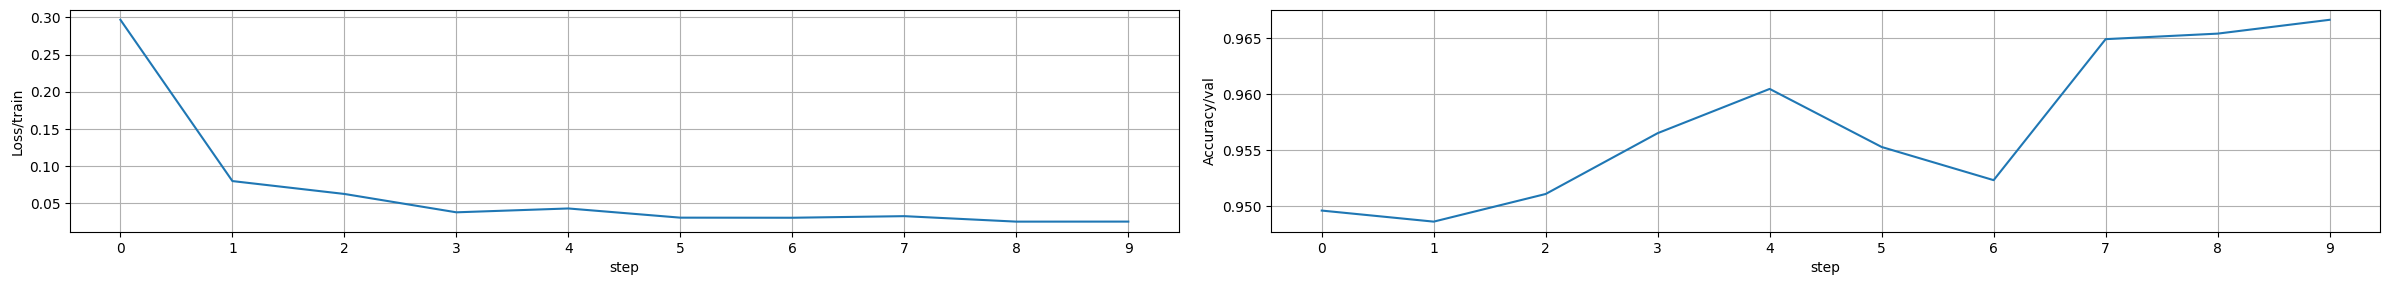

100%|██████████| 10/10 [04:50<00:00, 29.08s/it]


In [50]:
trainer = Trainer(
    model = CustomResnet_EarthSAT()
)
trainer.plotter = ProgressPlotter()
trainer.optimizer = optim.AdamW(trainer.model.model.parameters(), lr=0.0001, weight_decay=0.001)

trainer(train_loader, val_loader, epochs = 10)

##  Оцените точность

Оцените точность своей модели на `test_set`

In [51]:
trainer.model.model.eval()

acc = validate(trainer.model, test_loader, device)

print(f'Accuracy on test_set: {acc:.3f}')

Accuracy on test_set: 0.973


Loss ещё падает, accuracy стало выходить на плато, если дальше обучать модель, то может начаться переобучение